In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase
:e PackageImports


import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad.Bayes.Density.Free
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Sequential.Coroutine
import Control.Monad.Bayes.Inference.SMC

import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)
import Control.Applicative
import qualified Data.Text as T
import Pipes (Producer, (>->))
import qualified Pipes as P
import Pipes.Prelude (unfoldr)
import qualified Pipes.Prelude as P
import Data.Ord
import Data.List
import Control.Monad
import Control.Arrow (first)
import Numeric.Log
import Data.Vector qualified as V

import "matrix" Data.Matrix hiding ((!))
import Data.Vector.Generic as VG (Vector, map, mapM, null, sum, (!))

:l ../plotting.hs

# Sequential Inference

This tutorial discusses particle filters, and sequential Monte Carlo more generally.

These techniques are relevant when performing inference on models where there is a large series of factor statements, some of which can be performed earlier than others. This situation often arises in time series models where the factor statements are the result of incoming observations, but the technique works for *any* probabilistic program.

As a motivating example, consider the following program:

In [2]:
ex :: MonadMeasure m => Int -> m [Bool]
ex n = replicateM n do
    x <- bernoulli 0.5
    condition x
    return x

What distribution does this represent? It is the distribution over all lists of Booleans of length $n$, which for e.g. $n=4$, places all the weight on the sequence `[True,True,True,True]`. Function `condition` give a default score of 1 if x else 0 and effectively filters out all `False` values.

Function `normalForm` computes all possible combinations of discrete variable values, here a sequence of $n$ booleans, filters out ones with weight 0 and aggregates weights of equal values. 

In [3]:
normalForm $ ex 4

[([True,True,True,True],6.25e-2)]

In [4]:
explicit $ ex 2

[([True,True],0.25),([True,False],0.0),([False,True],0.0),([False,False],0.0)]

**This is inefficient**

However, the naive approach to exactly inferring this distribution will not work. Why? Because it first constructs all $2^n$ possible solutions, and then throws away all but one. This has complexity exponential in $n$ and for e.g. $n=100$, it is hopeless. 

Now if we look at the structure of the program, it's clear that this is unnecessary. Each time a `condition` statement is made, we should throw away all possibilities with $0$ probability mass. If we do this, the size of the set of possible solutions never explodes.

We can perform this *sequential enumeration* with monad-bayes, as follows:

In [5]:
enumerate $ sis removeZeros 100 $ ex 100

[([True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],1.0)]

`sis` (Sequential Importance Sampling) is an inference method which performs a step of inference at each `factor` statement in the program. In the present case, we have used it in conjunction with exact inference, but the idea generalizes naturally to approximate inference methods.


## Random walk example

To motivate sis with approximate inferece methods, let's examine a problem for which exact inference is no longer feasible, a non-linear state space model. Here we will make use of the [pipes](https://hackage.haskell.org/package/pipes-4.3.16/docs/Pipes-Prelude.html) library, which offers an elegant way to represent distributions over discrete random walks as infinite streams. See the `examples/Streaming` notebook for more info.

A `Producer` represents a stream of data, and a `Pipe` maps one stream to another. Both are parametrized by a monad `m`, which in our case will be `MonadDistribution m => m`. 

For example, a 2D random walk with a Gaussian `transition` kernel can be written as follows:

In [6]:
-- how to move from one latent state to the next 
-- for multivariate normal distribution
transition :: MonadDistribution m => V.Vector Double -> m (V.Vector Double)
transition vector = mvNormal (fmap (+0.5) vector) (identity (V.length vector))


-- For 2D case: a Markovian random walk starting at (0,0),
-- with `transition` as the kernel
-- a Producer is an infinite stream of values
prior :: MonadDistribution m => Producer (V.Vector Double) m r
prior = P.unfoldr (\s -> Right . (s,) <$> transition s) (V.fromList [0,0])

It's straightforward to take the first `n` steps of this infinite stream, and convert it into a distribution over finite list, from which we can then sample:

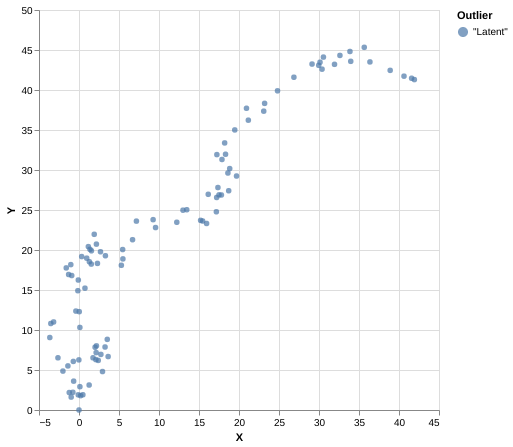

In [7]:
-- convert the stream to a list, taking only the first 100 steps
toList :: Monad m => P.Producer a m () -> m [a]
toList prod = P.toListM (prod >-> P.take 100)

randomWalkPrior <- sampleIOfixed $ toList prior

plot 
    (zip 
        (fmap (\v -> (v V.! 0, v V.! 1)) $ randomWalkPrior) 
        (replicate 100 (T.pack "Latent")))

We can also produce a stream of observations from `prior`, each a noisy perturbation of the datapoint in question, by using a `Pipe`:

In [8]:
observationModel = (`mvNormal` fromLists [[20,0],[0,20]])

observations :: MonadDistribution m => P.Pipe (V.Vector Double) (V.Vector Double) m ()
observations = P.mapM observationModel

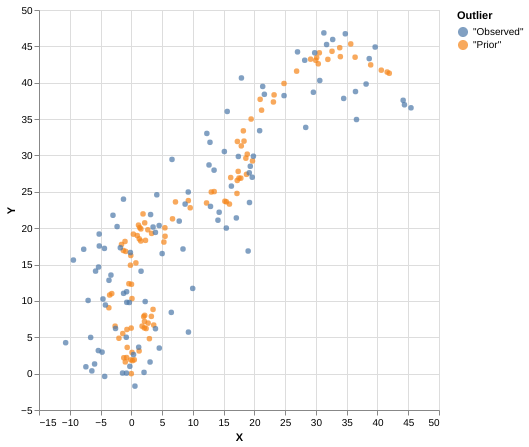

In [9]:
randomWalkObserved <- sampleIOfixed $ toList $ P.each randomWalkPrior >-> observations


plot 
    (zip 
        (fmap (\v -> (v V.! 0, v V.! 1)) $ randomWalkPrior <> randomWalkObserved) 
        (replicate 100 (T.pack "Prior") <> replicate 100 (T.pack "Observed")))

## Conditioning

But most interestingly, we can update our prior, based on a stream of incoming observations. `conditioning` below takes two `Producer`s, the stream corresponding to the prior (see `prior` above) and the stream corresponding to the observations (`P.each observedVectors`, where `P.each` lifts a list to a stream), and a likelihood, and returns a posterior, also expressed as a stream.  

In [10]:
-- take the original random walk as a prior and condition on the observations
-- to obtain a posterior random walk
conditioning :: MonadMeasure m => 
    P.Producer (V.Vector Double) m () -> 
    P.Producer (V.Vector Double) m () -> 
    ((V.Vector Double, V.Vector Double) -> m ()) ->
    P.Producer (V.Vector Double) m ()
conditioning prior observations observationModel = 
    P.zip prior observations
    >-> P.chain observationModel
    >-> P.map fst 


posterior :: MonadMeasure m => m [V.Vector Double]
posterior = toList $ conditioning 
    prior
    (P.each randomWalkObserved)
    (\(v, v') -> do
        prediction <- observationModel v
        let (x, y, x', y') = (prediction V.! 0, prediction V.! 1, v' V.! 0, v' V.! 1)
        factor $ normalPdf x 2 x' * normalPdf y 2 y' )


### Sequential Monte Carlo

We can then use an inference method of our liking, but in this tutorial, we would like to see how SMC behaves.

Following [Scibor et al](https://dl.acm.org/doi/pdf/10.1145/3236778):
> Within the context of SMC, recall
that a sample in a population is called a particle. The algorithm starts by initialising a population
of size n, then repeatedly runs the program to the next `score`, resamples the population, runs to
the next score and so on.

In [11]:
particles <- sampleIOfixed $ runPopulation $ 
    smc SMCConfig {
        numSteps = 100, 
        numParticles = 1000, 
        resampler = resampleMultinomial} 
    posterior

Distribution is generated over whole paths. We may compare realizations of prior and inferred (here 5 paths) with the observed path.

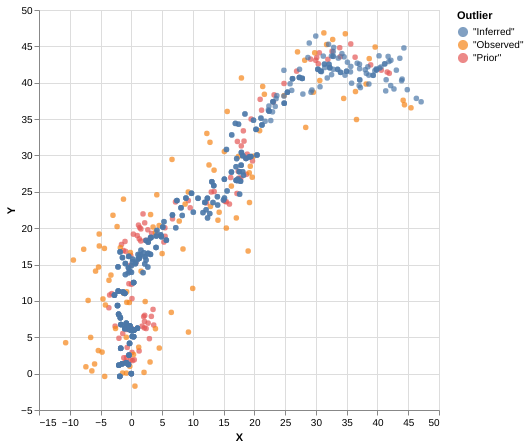

In [12]:
inferredVectors = fst =<< particles

plot 
    (zip 
        (fmap (\v -> (v V.! 0, v V.! 1)) $ randomWalkPrior <> randomWalkObserved <> inferredVectors) 
        (replicate 100 (T.pack "Prior") <> replicate 100 (T.pack "Observed") <> replicate 500 (T.pack "Inferred")))


We can see here that `SMC` has done a pretty good job.

The intuition of how SMC does well is that it is searching the space of solutions with some backtracking (because it has a whole population of guesses to rely on), and moreover, this search results in unbiased sampling from the distribution of interest. So if it makes a series of guesses the leads it astray, it can throw away this possiblity at a later stage. 